# Hidden on Variation


## Define Envs

In [1]:
from pathlib import Path

env_name = "CARLPendulumEnv"

database = {
    "CARLDmcWalkerEnv": {
        "result_dir": "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2022-12-14/10-47-33_benchmark_train",
        "folders_eval": [
            # "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-02-08/10-48-37",  # old magnitudes
            "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-02-14/14-09-02",  # new, more magnitudes
            
        ]
    },
    "CARLPendulumEnv": {
        # "result_dir": "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2023-01-05/09-01-41_benchmark_train",  # single variations
        "result_dir": "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2023-01-17/16-24-44_benchmark_train",  # varying all by a little
        "folders_eval": [
            # hidden
            "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-01-09",

            # cgate hadamard trained on []
            "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-01-16/09-12-59",

            # hidden + cgate_hadamard trained on 0.1 variations of all cfs
            "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-01-17/17-30-47",
        ]
    }
}

assert env_name in database

outdir = f"data/hidden_on_variations_new/{env_name}"
outdir = Path(outdir)
outdir.mkdir(exist_ok=True, parents=True)

## Define Test Contexts

In [ ]:
from itertools import product
import carl.envs
from experiments.common.utils.json_utils import lazy_json_dump
from pathlib import Path
import numpy as np
from rich import print as printr

env_class = eval(f"carl.envs.{env_name}")
module = env_class.__module__
default_context = eval(f"{module}.DEFAULT_CONTEXT")

context_path = outdir / "test_contexts.json"

magnitudes = np.arange(0.1, 2.3, 0.1)
magnitudes = np.round(magnitudes, 1)
# magnitudes = [0.5, 0.75, 0.9, 1., 1.1, 1.25, 1.5]

mask = []
for m in mask:
    if m in default_context:
        del default_context[m]

context_features = list(default_context.keys())

context_set = {}

for cf, mag in product(context_features, magnitudes):
    key = f"{cf}_{mag}"
    default = default_context[cf]
    if default == 0:
        value = mag + default
    else:
        value = mag * default
    context_set[key] = {cf: value}
    for k, v in default_context.items():
        if k != cf:
            context_set[key][k] = v

printr(f"Created context set with {len(context_set)} contexts.")
# printr(context_set)

lazy_json_dump(context_set, context_path)

full_path = Path(context_path).resolve()


## Find Agents & Print Eval Command

In [ ]:
from pathlib import Path
from rich import print as printr
from omegaconf import OmegaConf, ListConfig
from experiments.evaluation.loading import fn_config

# Train dir
result_dir = database[env_name]["result_dir"]

# Find agents
filters = {
    "wandb.group": "hidden",
    "context_sampler.context_feature_names": [],
    "context_sampler.uniform_bounds_rel": [0.9, 1.1],  # select one of the three
}
paths = list(Path(result_dir).glob(f"**/{fn_config}"))
valid_paths = []
for p in paths:
    cfg = OmegaConf.load(p)
    # printr(cfg)
    # break
    is_valid = True
    for key, value in filters.items():
        item = OmegaConf.select(cfg, key)
        if item != value:
            is_valid = False
            continue
    if is_valid:
        valid_paths.append(str(p)[:-len(fn_config)])
valid_paths.sort()
printr("N valid agents: ", len(valid_paths))
printr(valid_paths[0])

valid_paths_str = ",".join(valid_paths)

command = f"python experiments/evaluation/run_evaluation.py +experiments=hidden_on_variations 'hydra.launcher.timeout_min=720' 'contexts_path={full_path}' 'results_path={valid_paths_str}' -m"
print(command)





## Load Eval Data

In [2]:
import pandas as pd
import experiments.evaluation.loading
from importlib import reload
reload(experiments.evaluation.loading)

folders_eval = database[env_name]["folders_eval"]
rpc_fn = outdir / "rpc.csv"
reload = True

df = pd.concat([experiments.evaluation.loading.load(folder_eval=folder_eval, rpc_fn=rpc_fn, load_from_path=experiments.evaluation.loading.load_from_path_eval, reload_rpc=reload) for folder_eval in folders_eval]).reset_index(drop=True)

# Convert context ids in format context_feature_name_0.3 to separate vars
ids = df["context_id"].to_list()
for context_id in ids:
    # Get variation
    var = float(context_id.split("_")[-1])
    # Get contexet feature name
    cf = context_id[:len(str(var)) + 1]

from rich import print as printr

n_contexts = 35
n_cfs = 6
n_seeds = 10
n_reps = 10
n_samples = n_contexts * n_cfs * n_seeds * n_reps
printr(n_samples)


/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


21000

## Post Process Eval Data
Set proper column names, find out context feature and magnitude.

In [3]:
key_magnitude = r"$A$"
key_magnitude_train = r"$\Delta_{rel}$"

# Convert context ids in format context_feature_name_0.3 to separate vars
ids = df["context_id"].to_list()
context_features = []
magnitudes = []
for context_id in ids:
    # Get magnitude
    magnitude = float(context_id.split("_")[-1])
    # Get contexet feature name
    cf = context_id[:-(len(str(magnitude)) + 1)]

    magnitudes.append(magnitude)
    context_features.append(cf)
df["context_feature"] = context_features
df[key_magnitude] = magnitudes

for c in df.columns:
    printr(c, df[c].unique())

context_id ['max_speed_0.5' 'max_speed_0.75' 'max_speed_0.9' 'max_speed_1.0'
 'max_speed_1.1' 'max_speed_1.25' 'max_speed_1.5' 'dt_0.5' 'dt_0.75'
 'dt_0.9' 'dt_1.0' 'dt_1.1' 'dt_1.25' 'dt_1.5' 'g_0.5' 'g_0.75' 'g_0.9'
 'g_1.0' 'g_1.1' 'g_1.25' 'g_1.5' 'm_0.5' 'm_0.75' 'm_0.9' 'm_1.0' 'm_1.1'
 'm_1.25' 'm_1.5' 'l_0.5' 'l_0.75' 'l_0.9' 'l_1.0' 'l_1.1' 'l_1.25'
 'l_1.5']

return [-1153.544767   -1155.12893294 -1098.10983064 ...  -790.49604012
  -681.04061837  -826.10472891]

rep [0 1 2 3 4 5 6 7 8 9]

dt [0.05   0.025  0.0375 0.045  0.055  0.0625 0.075 ]

g [10.   5.   7.5  9.  11.  12.5 15. ]

l [1.   0.5  0.75 0.9  1.1  1.25 1.5 ]

m [1.   0.5  0.75 0.9  1.1  1.25 1.5 ]

max_speed [ 4.   6.   7.2  8.   8.8 10.  12. ]

visibility ['hidden' 'cgate_hadamard']

$\Delta_{rel}$ [0.1  0.25 0.5 ]

context_sampler.context_feature_names ['[]' "['m']" "['g']" "['l']" "['dt']" "['max_speed']"
 "['m', 'l', 'g', 'dt', 'max_speed']"]

seed [ 1  2  3  4  5  6  7  8  9 10]

algorithm ['td3']

context_feature ['max_speed' 'dt' 'g' 'm' 'l']

$A$ [0.5  0.75 0.9  1.   1.1  1.25 1.5 ]

## Plot ECDF & Histogram

42000


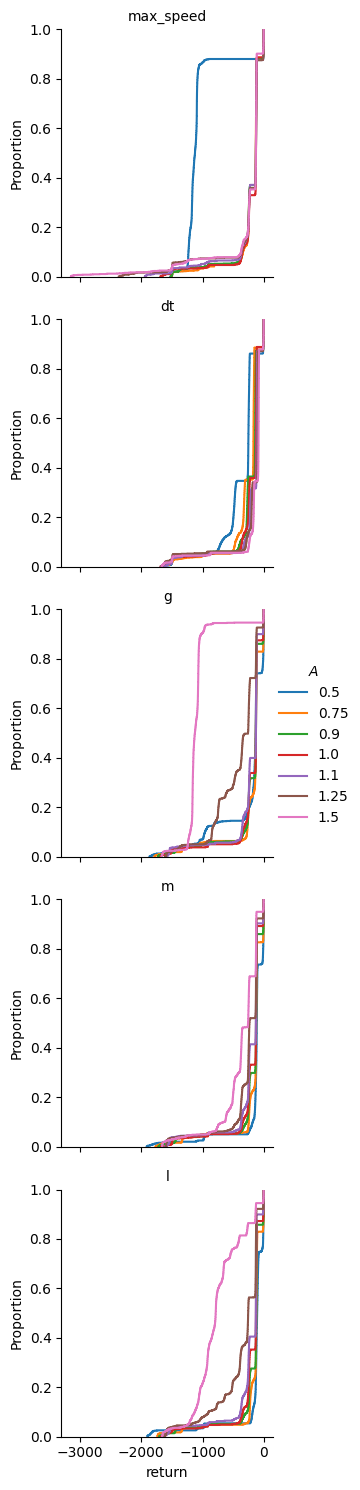

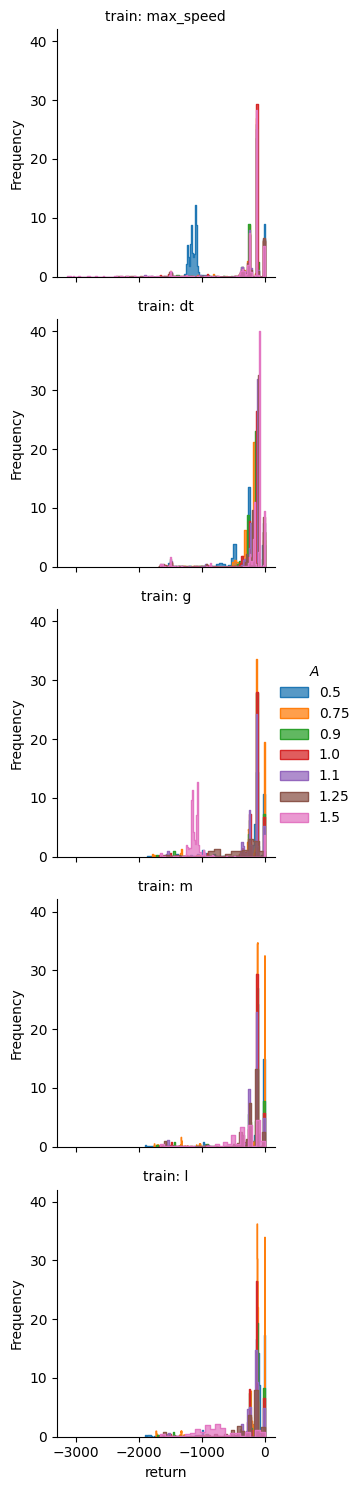

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = df.copy()
# Only those trained cfs allowed
context_feature_names = ['[]',]  #, "['m', 'l', 'g', 'dt', 'max_speed']"]
plot_df = plot_df[plot_df["context_sampler.context_feature_names"].isin(context_feature_names)]

# Only those visibilities allowed
visibilities = ['hidden', 'cgate_hadamard']
plot_df = plot_df[plot_df["visibility"].isin(visibilities)]

# We have hidden [] three times (one for each train magnitude), use only one to be fair
# magnitudes = [0.1]
# plot_df = plot_df[plot_df[key_magnitude_train].isin(magnitudes)]

# Filter by difficulty of test contexts
# magnitudes = [1.1]
# plot_df = plot_df[plot_df[key_magnitude].isin(magnitudes)]

# for c in plot_df.columns:
#     printr(c, plot_df[c].unique())

print(len(plot_df))

col = None  # "$A$"
row = "context_feature"  # "context_sampler.context_feature_names"
hue = key_magnitude  # "visibility"

# ECDF
grid = sns.FacetGrid(data=plot_df, col=col, row=row, hue=hue, legend_out=True)
grid.map_dataframe(sns.ecdfplot, x="return")
grid.set_titles(row_template="train: {row_name}", col_template="eval: {col_name}")
grid.set_titles(row_template="{row_name}", col_template="{col_name}")
grid.add_legend()
grid.savefig(outdir / "plot_ecdf.png", dpi=300, bbox_inches="tight")
plt.show()

# Histogram
grid = sns.FacetGrid(data=plot_df, col=col, row=row, hue=hue, legend_out=True)
grid.map_dataframe(sns.histplot, x="return", element="step", stat="frequency")
grid.set_titles(row_template="train: {row_name}", col_template="eval: {col_name}")
grid.add_legend()
grid.savefig(outdir / "plot_histogram.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ax = sns.boxplot(data=df[df[key] == "['l']"], x=r"$\Delta_{rel}$", y="return", hue="visibility")
# ax.set_title("l")
# plt.show()

print(len(df[df["visibility"] == "cgate_hadamard"]))

# df = df[df["visibility"] == "hidden"]

grid = sns.FacetGrid(data=df, col=r"$\Delta_{rel}$", row="visibility", hue="context_sampler.context_feature_names", legend_out=True)
grid.map_dataframe(sns.kdeplot, x="return")
grid.set_titles(row_template="{row_name}", col_template="{col_name}")
grid.add_legend()
plt.show()


# grid = sns.FacetGrid(data=df, hue=r"$\Delta_{rel}$", row="context_sampler.context_feature_names", legend_out=True)
# grid.map_dataframe(sns.kdeplot, x="return")
# grid.add_legend()
# grid.set_titles(row_template="{row_name}")
# plt.show()

key = "context_sampler.context_feature_names"
grid = sns.FacetGrid(data=df[(df[key] == "[]") | (df[key] == "['l']")], col=r"$\Delta_{rel}$", row="visibility", hue="context_sampler.context_feature_names", legend_out=True)
grid.map_dataframe(sns.kdeplot, x="return")
grid.set_titles(row_template="{row_name}", col_template="{col_name}")
grid.add_legend()
plt.show()

sns.boxplot(data=df[(df[key] == "[]") | (df[key] == "['l']")], x=r"$\Delta_{rel}$", y="return", hue=key)
plt.show()

